In [1]:
#IMPORTAZIONE LIBRERIE GENERALI

import pandas as pd
pd.options.display.max_rows = 100
pd.options.display.max_columns = 20

import numpy as np

import matplotlib.pyplot as plt
plt.style.use('default') # to plot white graphs despite black background
import seaborn as sns
sns.set_style('darkgrid', {'axes.facecolor': '0.9'})
#sns.set_style('whitegrid')

from datetime import timedelta
from dateutil.relativedelta import relativedelta

import math

from scipy.stats import norm

#import warnings
#warnings.filterwarnings('ignore')

In [2]:
#**************************************************************************************************************************
#**************************************************************************************************************************
#**************************************************************************************************************************

In [4]:
data = pd.read_csv(r'C:\Users\peria\Desktop\Github\Data Science For Supply Chain Forecasting\norway_new_car_sales_by_make.csv')

data.head()

Year  Month        Make  Quantity   Pct
0  2007      1      Toyota      2884  22.7
1  2007      1  Volkswagen      2521  19.9
2  2007      1     Peugeot      1029   8.1
3  2007      1        Ford       870   6.9
4  2007      1       Volvo       693   5.5

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4377 entries, 0 to 4376
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Year      4377 non-null   int64  
 1   Month     4377 non-null   int64  
 2   Make      4367 non-null   object 
 3   Quantity  4377 non-null   int64  
 4   Pct       4377 non-null   float64
dtypes: float64(1), int64(3), object(1)
memory usage: 171.1+ KB


In [6]:
def create_period(A):
    
    # Create a double digit month
    A['Month'] = str(A['Month'])
    A['Month'] = '0' + A['Month'] if len(A['Month']) < 2 else A['Month']
    
    # Create Period
    A['Period'] = str(A['Year']) + '-' + A['Month']
    
    return(A)

data = data.apply(create_period, axis = 1)
data.head()

Year Month        Make  Quantity   Pct   Period
0  2007    01      Toyota      2884  22.7  2007-01
1  2007    01  Volkswagen      2521  19.9  2007-01
2  2007    01     Peugeot      1029   8.1  2007-01
3  2007    01        Ford       870   6.9  2007-01
4  2007    01       Volvo       693   5.5  2007-01

Da subito ci sono 2 cose da chiedersi:
1) Ci sono dei dati **null** ?

2) Tutte le case automobilistiche hanno macchine vendute in ogni periodo e quindi la sequenza di mesi per ogni casa è sempre completa ?

Come vedremo qui sotto:
1) Sì, ci sono dei dati **null**

2) Sì, alcune case, come la Saab, **hanno meno date degli altri paesi**, quindi bisognerà tenerne di conto

In [7]:
data.isnull().sum()

Year         0
Month        0
Make        10
Quantity     0
Pct          0
Period       0
dtype: int64

In [8]:
data[data['Make'].isnull()]

Year Month Make  Quantity  Pct   Period
37    2007    01  NaN         1  0.0  2007-01
112   2007    03  NaN         1  0.0  2007-03
265   2007    07  NaN         1  0.0  2007-07
419   2007    11  NaN         1  0.0  2007-11
1256  2009    09  NaN         4  0.0  2009-09
1294  2009    10  NaN         4  0.0  2009-10
2399  2012    04  NaN         1  0.0  2012-04
2478  2012    06  NaN         1  0.0  2012-06
2517  2012    07  NaN         1  0.0  2012-07
3013  2013    09  NaN         1  0.0  2013-09

In [9]:
data['Make'].value_counts() # Conto per ogni casa automobilistica il numero di date presenti

Lexus            122
Toyota           121
Mazda            121
Volkswagen       121
Subaru           121
MINI             121
Kia              121
Hyundai          121
Nissan           121
Mitsubishi       121
Renault          121
Fiat             121
Land Rover       121
Suzuki           121
Citroen          121
BMW              121
Mercedes-Benz    121
Honda            121
Audi             121
Opel             121
Skoda            121
Volvo            121
Ford             121
Peugeot          121
Alfa Romeo       117
Jaguar           117
Porsche          117
Smart            110
Jeep             109
Chevrolet         94
Ssangyong         80
Tesla             77
Saab              69
Daihatsu          58
Dacia             56
Nilsson           54
Think             54
Dodge             48
Chrysler          43
Morgan            31
Cadillac          27
Aston Martin      27
Iveco             27
Maserati          26
Ferrari           21
DS                14
Isuzu             14
Lancia       

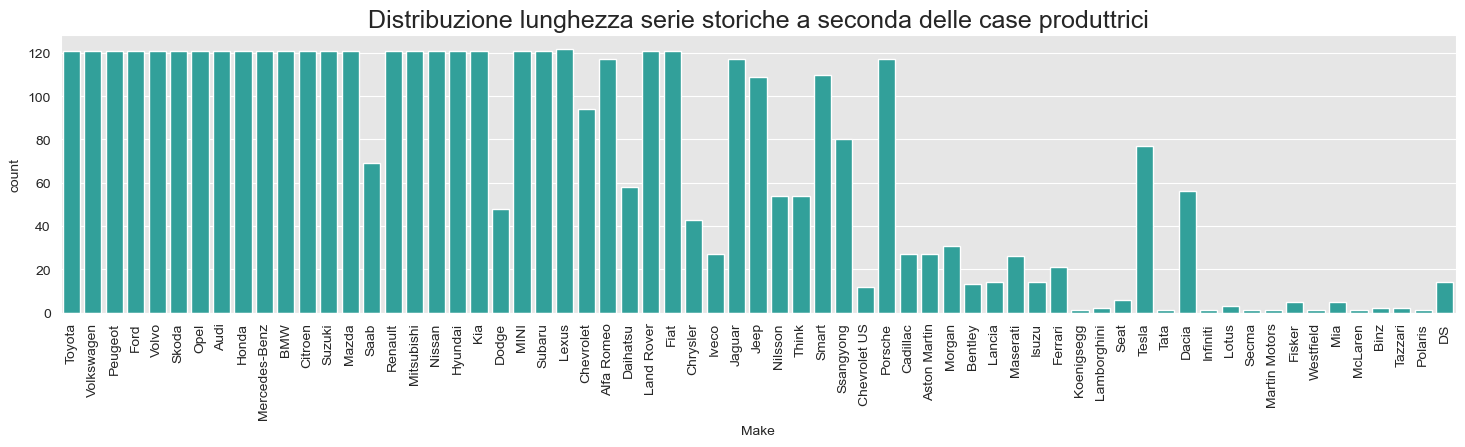

In [10]:
fig, ax = plt.subplots(1, 1, figsize = (18, 3.6))

sns.countplot(x = data['Make'], ax = ax, color = 'lightseagreen')

ax.set_title('Distribuzione lunghezza serie storiche a seconda delle case produttrici', fontsize = 18)

plt.xticks(rotation = 90)

plt.show()

In [11]:
# Per ogni riga, a seconda della casa automobilistica, inserisco il numero di date presenti

def count_len_group(group):
    group['len_group'] = len(group)
    return(group)

data = data.groupby('Make').apply(count_len_group)
data.head()

Year Month        Make  Quantity   Pct   Period  len_group
0  2007    01      Toyota      2884  22.7  2007-01        121
1  2007    01  Volkswagen      2521  19.9  2007-01        121
2  2007    01     Peugeot      1029   8.1  2007-01        121
3  2007    01        Ford       870   6.9  2007-01        121
4  2007    01       Volvo       693   5.5  2007-01        121

In [12]:
# Si vede che la Saab salta alcune date, ad esempio manca 2012-09 e 2012-10

data.groupby('Make').get_group('Saab').tail(10)

Year Month  Make  Quantity  Pct   Period  len_group
2289  2012    01  Saab         1  0.0  2012-01         69
2321  2012    02  Saab         2  0.0  2012-02         69
2363  2012    03  Saab         1  0.0  2012-03         69
2432  2012    05  Saab         2  0.0  2012-05         69
2473  2012    06  Saab         1  0.0  2012-06         69
2509  2012    07  Saab         2  0.0  2012-07         69
2552  2012    08  Saab         1  0.0  2012-08         69
2659  2012    11  Saab         1  0.0  2012-11         69
2769  2013    02  Saab         1  0.0  2013-02         69
2874  2013    05  Saab         1  0.0  2013-05         69

# PIVOT da data a df

In [13]:
df = pd.pivot_table(data = data, 
                    index = 'Make', columns = 'Period', values = 'Quantity', 
                    aggfunc = 'sum', 
                    fill_value = 0)
df.head()

Period        2007-01  2007-02  2007-03  2007-04  2007-05  2007-06  2007-07  \
Make                                                                          
Alfa Romeo         16        9       21       20       17       21       14   
Aston Martin        0        0        1        0        4        3        3   
Audi              599      498      682      556      630      498      562   
BMW               352      335      365      360      431      477      403   
Bentley             0        0        0        0        0        1        0   

Period        2007-08  2007-09  2007-10  ...  2016-04  2016-05  2016-06  \
Make                                     ...                              
Alfa Romeo         12       15       10  ...        3        1        2   
Aston Martin        0        0        0  ...        0        0        1   
Audi              590      393      554  ...      685      540      551   
BMW               348      271      562  ...     1052      832      808   
Bentley             0        0        0  ...        0        0        1   

Period        2016-07  2016-08  2016-09  2016-10  2016-11  2016-12  2017-01  
Make                                                                         
Alfa Romeo          1        6       15        3        4        3        6  
Aston Martin        0        0        0        0        0        0        0  
Audi              687      794      688      603      645      827      565  
BMW               636     1031     1193     1096     1663      866     1540  
Bentley             1        1        0        0        0        0        0  

[5 rows x 121 columns]

Nonostante ad alcune case mancassero delle date, qui non vedo valori NaN. Il motivo è che ci ha messo 0. Ad esempio la Saab non ha 2012-09 e 2012-10. Quindi adesso posso anche plottare visto che il dataset è completo e tutte le case hanno tutte le date

In [14]:
# Nonostante ad alcune case mancassero delle date, qui non vedo valori NaN

df.isnull().sum()[df.isnull().sum() == 0].any()

False

In [15]:
# Il motivo è che ci ha messo 0. Ad esempio la Saab non ha 2012-09 e 2012-10
df.loc['Saab', '2012-09':'2012-10']

Period
2012-09    0
2012-10    0
Name: Saab, dtype: int64

#### Quindi adesso posso anche plottare visto che il dataset è completo e tutte le case hanno tutte le date

fig, ax = plt.subplots(figsize = [15, 6.5])


for j in ['Saab', 'Citroen', 'Fiat', 'Renault']:
    ax.plot(df.loc[j,:], marker = 'o', markersize = 4, label = j)

step = 4
xlab = [pd.to_datetime(df.columns[0]) + relativedelta(months = j) for j in np.arange(0, len(df.columns), step)]
ax.set_xticklabels(xlab, rotation = 90)
ax.set_xticks(np.arange(0, len(df.columns), step))

ax.legend(edgecolor = 'red', facecolor = 'white', fontsize = 13, loc = 'best')

plt.show()

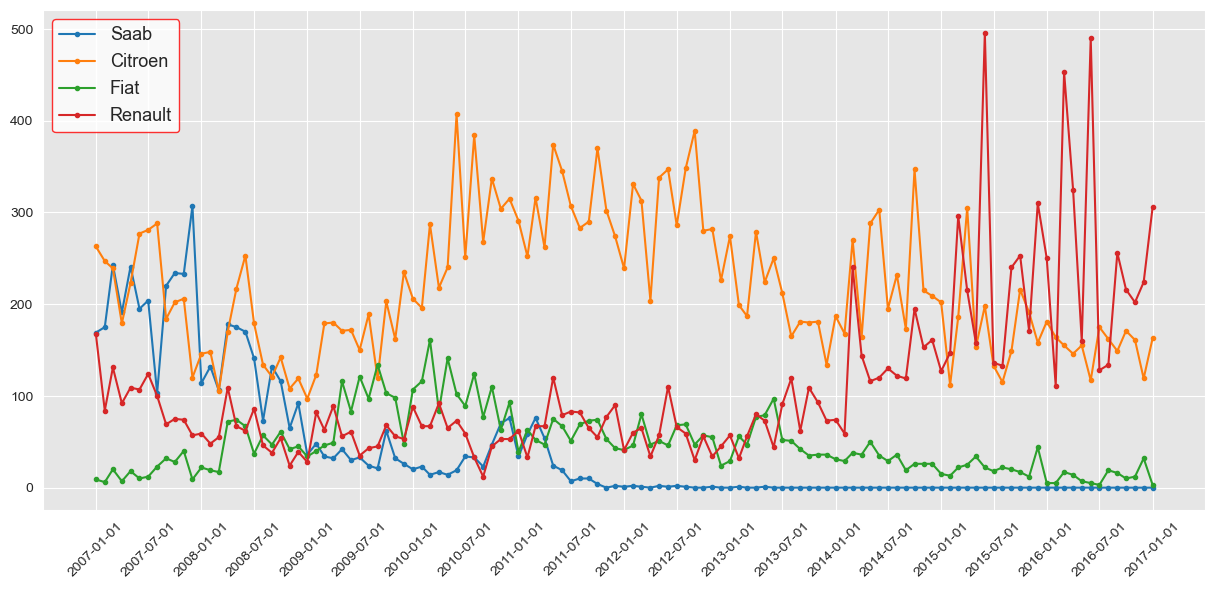

In [16]:
# Quindi adesso posso anche plottare visto che il dataset è completo e tutte le case hanno tutte le date

fig, ax = plt.subplots(figsize = [15, 6.5])

df_to_plot = df.T
df_to_plot.index = pd.to_datetime(df_to_plot.index, format = '%Y-%m-%d')

for brand in ['Saab', 'Citroen', 'Fiat', 'Renault']:
    ax.plot(df_to_plot[brand], marker = 'o', markersize = 3, label = brand)

step = 6
ax.set_xticks( df_to_plot.index[ [j for j in np.arange(0, len(df_to_plot.index), step)] ] )
ax.tick_params(axis = 'x', rotation = 45)

ax.legend(edgecolor = 'red', facecolor = 'white', fontsize = 13, loc = 'best')

plt.show()

In [17]:
###########################################################################################################################

In [18]:
###########################################################################################################################

# Creazione dataset

Esempio con F, H, G solo per capire cosa verrà fatto nella creazione del dataset

In [19]:
F = np.array([[1,2,3], [4,5,6], [7,8,9], [1,2,4]])
H = np.array([[1,5,7], [1,7,8], [7,8,9], [1,2,4]])
G = [F,H]

In [20]:
G = np.vstack(G)
G

array([[1, 2, 3],
       [4, 5, 6],
       [7, 8, 9],
       [1, 2, 4],
       [1, 5, 7],
       [1, 7, 8],
       [7, 8, 9],
       [1, 2, 4]])

In [21]:
G_train, G_test = np.split(G, [-1], axis = 1)

G_train, G_test

(array([[1, 2],
        [4, 5],
        [7, 8],
        [1, 2],
        [1, 5],
        [1, 7],
        [7, 8],
        [1, 2]]),
 array([[3],
        [6],
        [9],
        [4],
        [7],
        [8],
        [9],
        [4]]))

In [22]:
U = np.full((6, 1), np.nan)
U

array([[nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan]])

In [23]:
U.ravel()

array([nan, nan, nan, nan, nan, nan])

In [24]:
###########################################################################################################################

Questa riga di codice serve solo per visualizzare la tabella in excel che si vede meglio

In [25]:
#df.to_csv(r'C:\Users\peria\Desktop\DATA SCIENCE\TIME SERIES\Data Science For Supply Chain Forecasting\pivot_norway_new_car_sales_by_make.csv')

Questa immagine è solo esplicativa del processo che si segue per organizzare una tabella che consenta di fare time series forecasting sfruttando le tecniche di machine learning, ma i dati ovviamente non sono quelli stored in df.

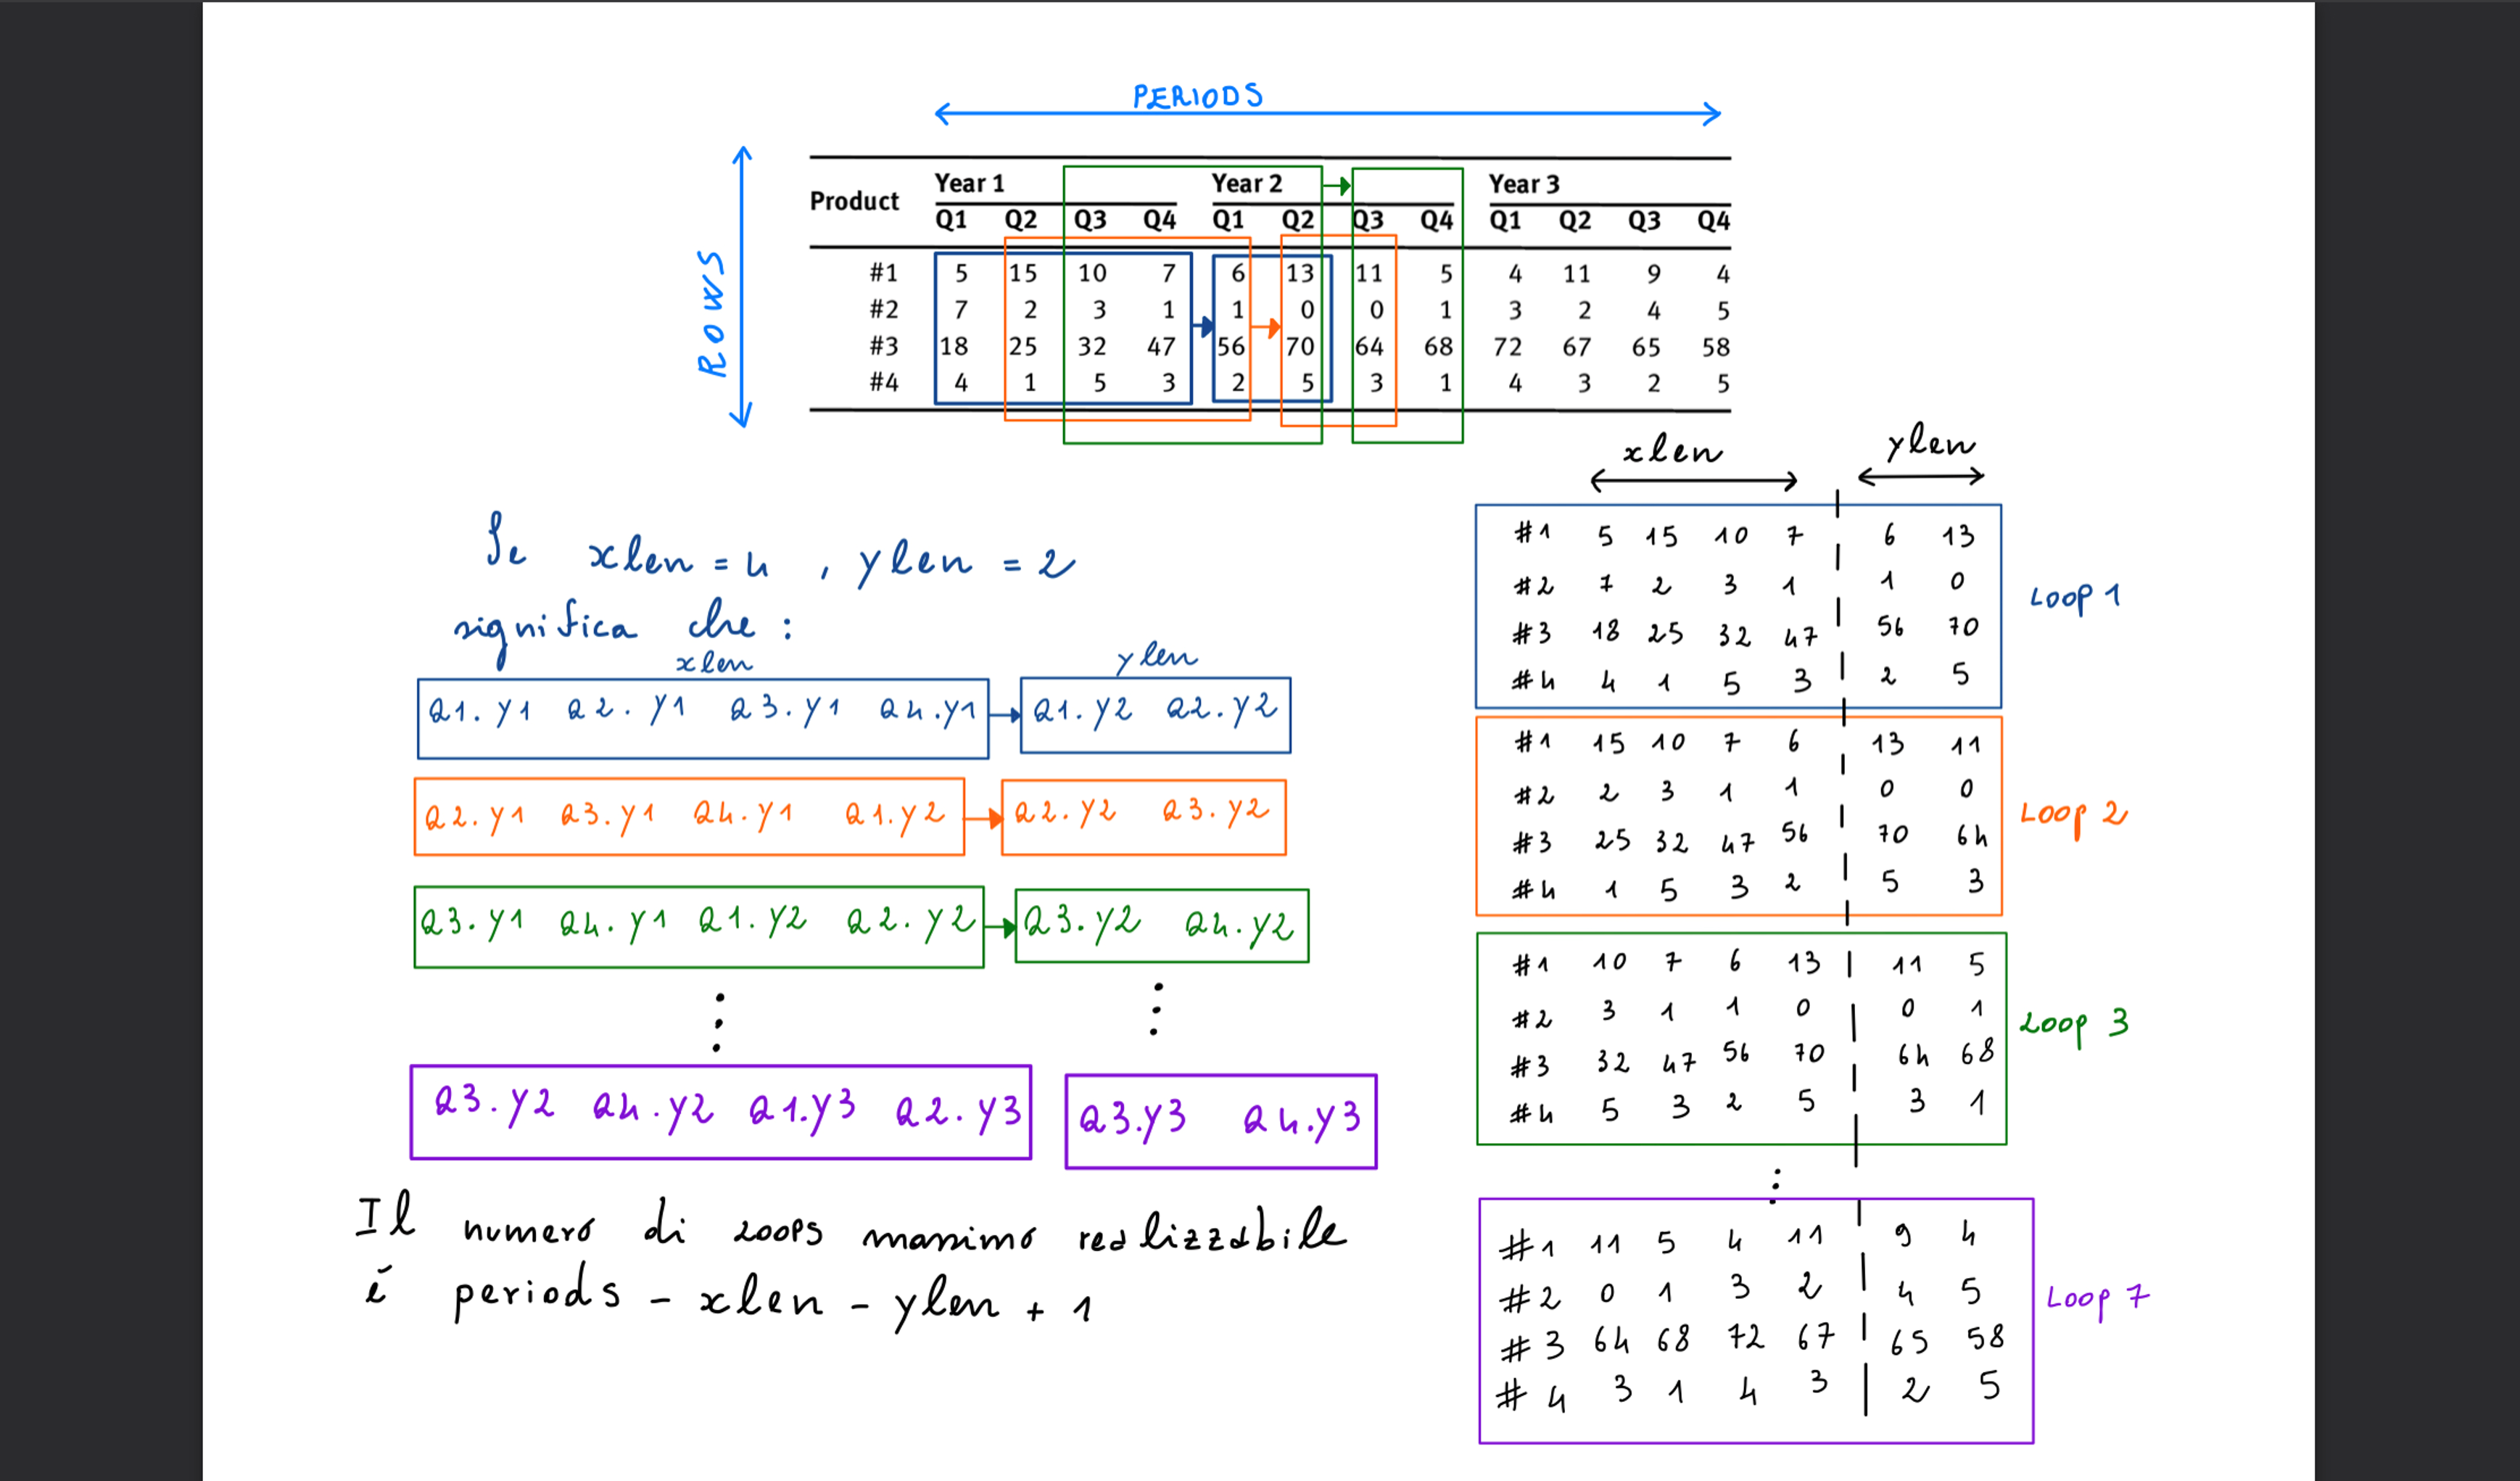

In [26]:
def create_dataframe(A, xlen, ylen, test_loops):
    
    periods_considered = A.columns
    print('1st fitted value on the training set : ', periods_considered[xlen])
    print('Last fitted value on the training set : ', periods_considered[-test_loops-1])
    
    D = A.values
    rows, periods = D.shape
    
    #1) CREAZIONE TRAIN
    
    loops = periods - xlen - ylen + 1
    
    train = [] #diventerà una lista di array che vengono appesi con il ciclo sottostante
    
    # A ogni iterazione appendo un array composto da tutte le righe di A ma solo xlen+ylen colonne di volta in
    # volta spostandosi a destra di 1 colonna
    for col in range(loops): 
        train.append(D[ : , col : col+xlen+ylen ])
    
    # Da una lista di array creo un unico 2d-array dove ogni riga è una macchina e ogni colonna è un periodo:
    # in ogni riga ci sono (xlen+ylen) periodi adiacenti e l'idea è di usare (xlen periodi) per predire 
    # i successivi (ylen periodi)
    train = np.vstack(train)
    
    # Splitto il mio 2d-array in 2 array: X_train e y_train. Nell'argomento di split viene specificato il numero di
    # colonne che deve avere y_train, ovvero ylen e per differenza X_train avrà xlen colonne
    X_train, y_train = np.split(train, [-ylen], axis = 1)
    
    
    # 2) CREAZIONE TEST
    
    # Se voglio fare una validazione e quindi rinunciare a una parte delle osservazioni in fase di training per poi
    # usarle in fase di test, splitto X_train in un X_train più piccolo e in X_test.
    # La stessa identica cosa faccio con y_train
    if test_loops > 0: 
        X_train, X_test = np.split(X_train, [-rows*test_loops], axis = 0)
        y_train, y_test = np.split(y_train, [-rows*test_loops], axis = 0)
        print('1st predictable test period : ', periods_considered[-test_loops-ylen+1])
        print('Last predictable test period : ', periods_considered[-1])
        
    # Se invece non voglio fare validazione ma solo forecast futura, utilizzo le ultime xlen colonne di D per 
    # fare la previsione 
    else:
        X_test = D[:, -xlen:] # uso le ultime xlen colonne per fare una previsione
        #X_test = train[-rows:, -xlen:] #alternativamente alla riga sopra
        y_test = np.full((X_test.shape[0], ylen), np.nan) # y_test fatto di NaN ha le stesse righe di X_test e ylen colonne
    
    # In accordo a come vuole gli array scikit-learn
    if ylen == 1:
        y_train = y_train.ravel()
        y_test = y_test.ravel()
        
    return (X_train, y_train, X_test, y_test)

## ATTENZIONE !

- Più xlen è elevato ===> più periodi utilizzo come predittori dell'uscita y ===> meno loop posso eseguire. Paradossalmente se sfruttassi tutti i periodi tranne l'ultimo (i.e. xlen = periods - 1 e ylen = 1) allora il loop sarebbe solo 1


- Se voglio fare previsioni di **più periodi in un colpo** (**i.e. multiple periods time series forecasting con la tecnica multiple regression**) anche questo ci consente di fare meno loop e quindi avere meno righe nel training


- Dovrò poi tenere fuori alcune righe di test che riduce ulteriormente la dimensione del campione su cui si addestrano gli algoritmi


- Se il dataset ha **n periodi** (i.e. n colonne ognuna delle quali è un periodo) ===> **loops = n - xlen - ylen + 1**


- Quando si sceglie la dimensione del test (i.e. il numero di righe di **X_test** e **y_test**, che è ovviamente il solito) è opportuno coprire abbastaza periodi da coprire un intera stagione di lunghezza **slen**. Quindi
    - **loops_test = slen** ===> **len(y_test) = len(X_test) = slen * #prodotti**
    - **loops_train = periods - xlen - ylen + 1 - slen**

In [27]:
#**************************************************************************************************************************

# Creazione (X_train, y_train, X_test, y_test)

In [28]:
xlen = 12
ylen = 1
loops = df.shape[1] - xlen - ylen + 1
test_loops = 24

(X_train, y_train, X_test, y_test) = create_dataframe(df, xlen = xlen, ylen = ylen, test_loops = test_loops)

1st fitted value on the training set :  2008-01
Last fitted value on the training set :  2015-01
1st predictable test period :  2015-02
Last predictable test period :  2017-01


In [29]:
#X_train

In [30]:
#y_train

In [31]:
#X_test

In [32]:
y_test

array([   1,    0,  474, ..., 1688, 1158,    0], dtype=int64)

In [33]:
print('Dimensioni dataset di training: \n', 'X_train: ', X_train.shape, '\n y_train: ', y_train.shape, '\n\n')
print('Dimensioni dataset di testing: \n', 'X_test: ', X_test.shape, '\n y_test: ', y_test.shape)

Dimensioni dataset di training: 
 X_train:  (5525, 12) 
 y_train:  (5525,) 


Dimensioni dataset di testing: 
 X_test:  (1560, 12) 
 y_test:  (1560,)


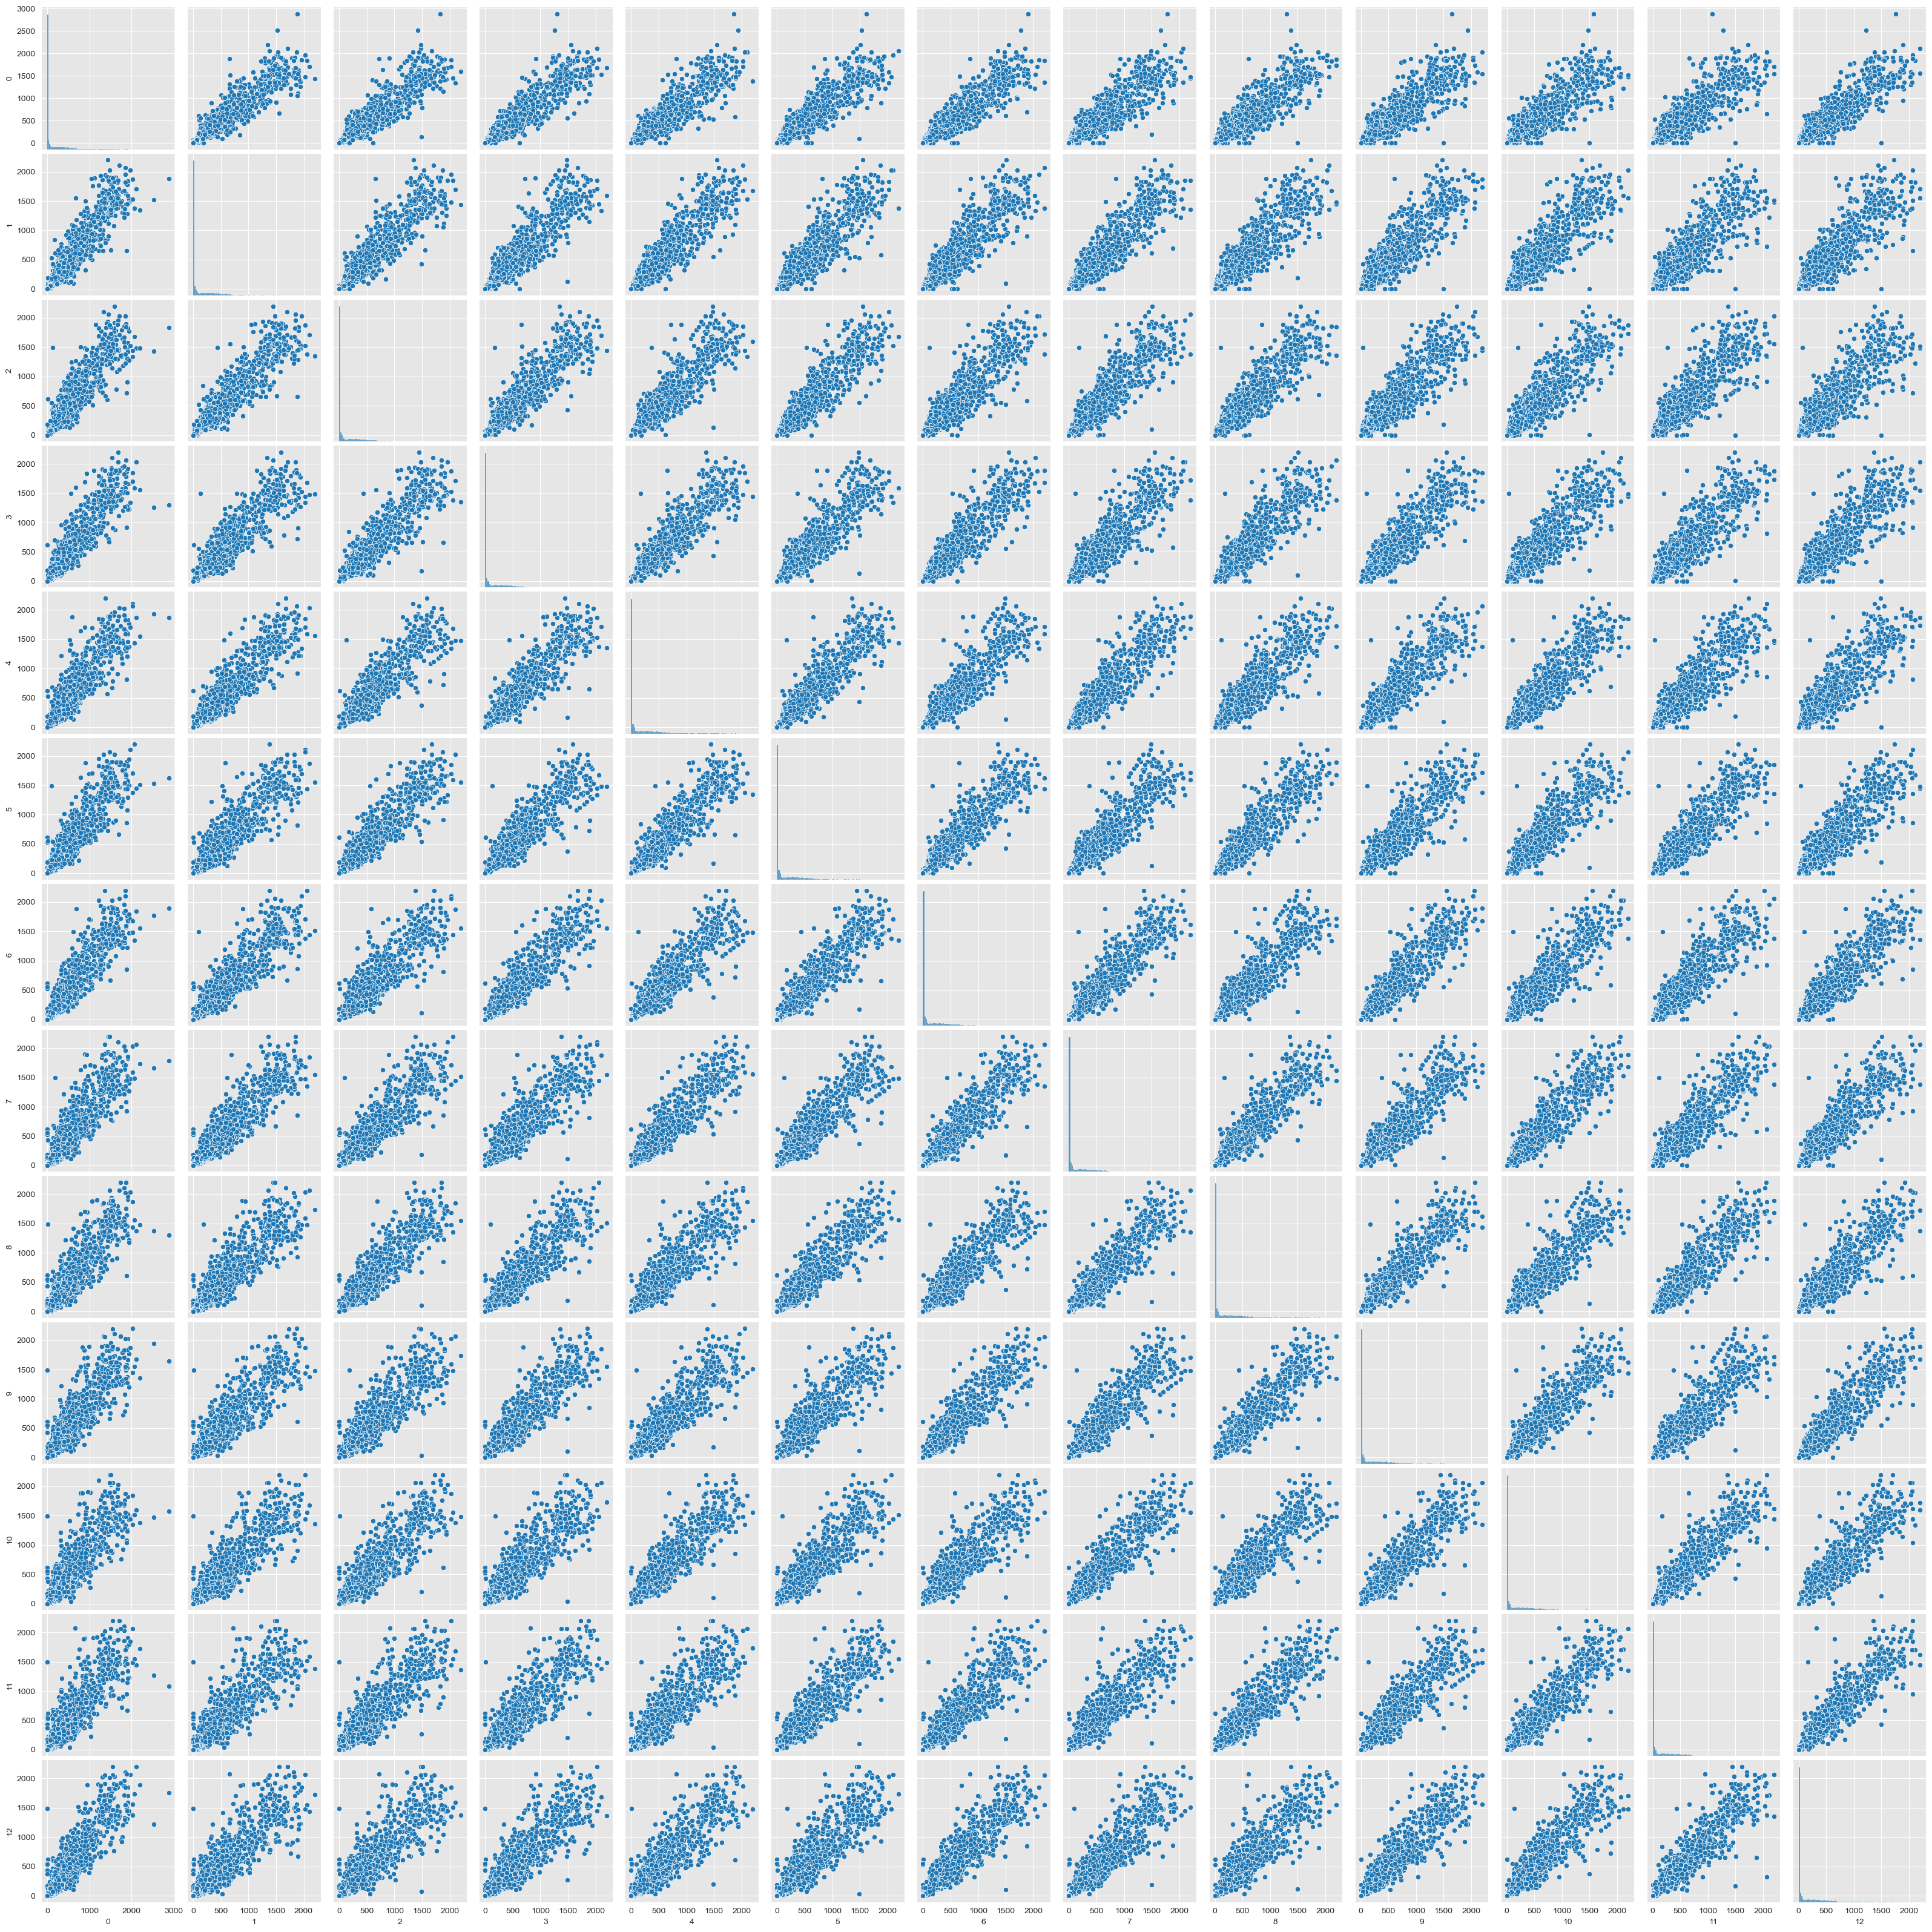

In [43]:
_ = np.hstack([X_train, y_train.reshape(len(y_train), 1)])
cols = ['X' + str(j+1) for j in range( _.shape[1]-1) ].append('y')
_ = pd.DataFrame( _, columns = cols)
sns.pairplot(data = _, diag_kind = 'hist')

In [44]:
##################################################################################################################################

In [45]:
##################################################################################################################################

# LINEAR REGRESSION - previsione 1 periodo => ylen = 1

La **regressione lineare multivariata** viene di solito utilizzata come benchmark, in quanto dà buone prestazioni solo se le serie sono più o meno regolari

In [46]:
# IMPORT MODEL
from sklearn.linear_model import LinearRegression
model = LinearRegression() # Create linear regression object

# TRAINING 
model.fit(X_train, y_train) # Train linear regression object by fitting X_train, y_train

LinearRegression()

In [47]:
# Coefficienti regressione
coefs = model.coef_
coefs = np.append(model.intercept_, coefs)
print('\nCoefficient estimates:\n', coefs)


Coefficient estimates:
 [ 1.34319614  0.30350647 -0.0256827  -0.11516774 -0.06827568 -0.03275787
 -0.00655198  0.14215958  0.05027012  0.04218982  0.19993188  0.23595527
  0.27187123]


## - - - Analisi dei residui sul dataset di training (X_train, y_train) - - -
## - - - Calcolo y_train_pred

In [48]:
# PREDICTION SUL TRAIN per VEDERE COME FITTA IL MODELLO
y_train_pred = model.predict(X_train) # per visualizzare modello lineare fittato su X_train, y_train

# Residui
resid_train = y_train - y_train_pred

print('Prediction:\n', y_train_pred, '\n\nResiduals:\n', resid_train)

Prediction:
 [1.66717764e+01 1.50381970e+00 4.98155956e+02 ... 1.88645630e+03
 1.18274633e+03 1.34319614e+00] 

Residuals:
 [  -1.67177637   -1.5038197   -69.15595633 ...  170.54369617 -861.74632513
   -1.34319614]


In [49]:
mu_resid_train = resid_train.mean()
std_resid_train = resid_train.std()

mu_resid_train, std_resid_train

(2.6482345728094087e-14, 73.01989733069638)

In [50]:
skewness = (1/len(resid_train)) * np.sum( (resid_train - mu_resid_train)**3 ) / std_resid_train**3
kurtosis = (1/len(resid_train)) * np.sum( (resid_train - mu_resid_train)**4 ) / std_resid_train**4

skewness, kurtosis

(0.99029073868507, 35.912701496869545)

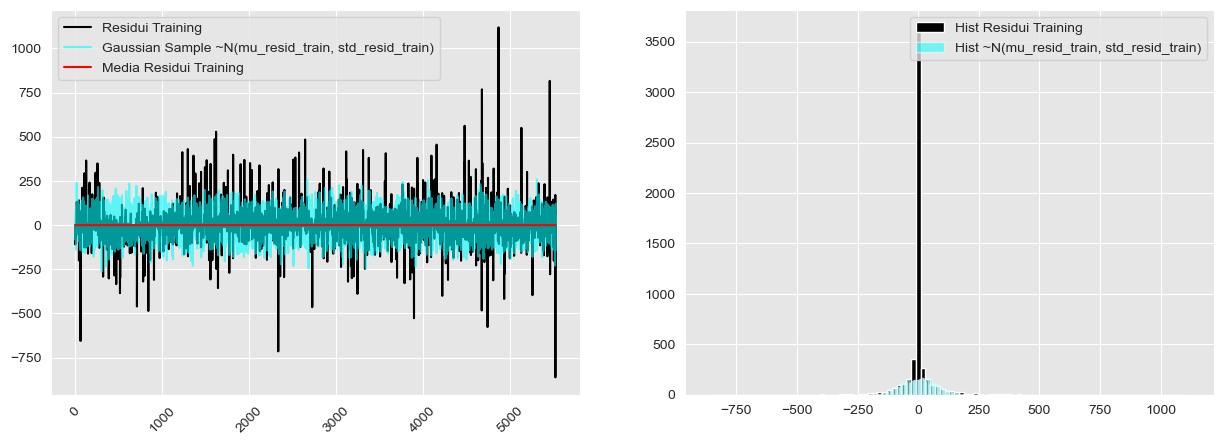

In [51]:
fig, ax = plt.subplots(1, 2, figsize = (15, 5))

sample = std_resid_train * np.random.randn(len(resid_train)) + mu_resid_train

# Andamento domanda
ax[0].plot( resid_train, color = 'black', label = 'Residui Training')
ax[0].plot( sample, color = 'cyan', label = 'Gaussian Sample ~N(mu_resid_train, std_resid_train)', alpha = 0.6)
ax[0].plot( mu_resid_train*np.ones(len(resid_train)), color = 'red', label = 'Media Residui Training')



# Hist domanda
ax[1].hist( resid_train , color = 'black', bins = 100, label = 'Hist Residui Training')

ax[1].hist(sample, color = 'cyan', alpha = 0.5, bins = 100, label = ['Hist ~N(mu_resid_train, std_resid_train)'])

ax[0].tick_params(axis='x', labelrotation = 45)
ax[0].legend()
ax[1].legend()

plt.show()

C:\Users\peria\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
C:\Users\peria\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


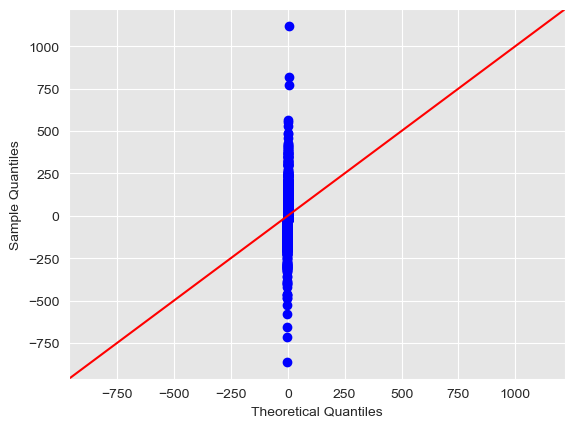

In [52]:
import statsmodels.api as sm
sm.qqplot(resid_train, line ='45')
plt.show()

## - - - Calcolo statistiche sui coefficienti - - -

Di seguito calcolo alcune statistiche sui coefficienti, come:
- $\sigma_{\hat{\beta}}^{2} = \sigma^{2} (X^{T}X)^{-1}_{jj}$ con $\sigma^{2} = \frac{1}{n - p}\sum\limits_{i = 1}^{n}(y_{i} - \hat{y_{i}})^{2} = \frac{1}{n - p}\sum\limits_{i = 1}^{n}\epsilon_{i}^{2}$

-  $\sigma_{\hat{\beta}}$


- t_value => Valore t corrispondete al p-value del test statistico t-Student con H0:$\beta_{j} = 0$


- p_value del test statistico t-Student con H0:$\beta_{j} = 0$

In [53]:
# Nel calcolare XT_X, aggiungo a X il vettore colonna di 1 per tenere conto dell'intercetta
n = X_train.shape[0]
X_train_stacked_1 = np.column_stack((np.ones(n), X_train))
p = X_train_stacked_1.shape[1]

XT_X = np.matmul(np.transpose(X_train_stacked_1), X_train_stacked_1)
XT_X_inv = np.linalg.inv(XT_X)
# Calcolo la stima di sigma
sigma = (1/(n-p)) * np.sum((resid_train)**2, axis = 0)

# Calcolo la varianza di ognuno dei beta
Var_coefs = sigma * XT_X_inv.diagonal()

# Calcolo della deviazione standard (errore standard) dei beta
sd_coefs = np.sqrt(Var_coefs)

# Adesso creo la variabile Z con cui farò il t-test
Z = coefs / sd_coefs


# Adesso calcolo i p-value associati ai vari test con H0: beta0 = 0 , H0 : beta1 = 0, ..., H0: betap = 0
# Nota che siccome il test è BILATERO, devo moltiplicare davanti per 2
from scipy.stats import t as t_test
p_values = []
for j in Z:
    p_values.append( 2 * (1 - t_test.cdf(np.abs(j), n-p)) ) #moltiplico per 2 perché il test è bilatero
p_values = np.array(p_values)
print('\nI p-value associati ai beta = [beta0, beta1, ..., beta_p] sono: \n\n', np.round(p_values, 5))


df_summary = pd.DataFrame({'Beta': np.round(coefs, 3),
                           'Var_Beta': np.round(Var_coefs, 3),
                           'Std_Beta': np.round(sd_coefs, 3),
                           't_values': np.round(Z, 3),
                           'p_values': np.round(p_values, 3)})

idx = ['Vettore_di_1']
for j in range(1, X_train_stacked_1.shape[1]):
    idx.append('X' + str(j))
df_summary.index = idx
df_summary


I p-value associati ai beta = [beta0, beta1, ..., beta_p] sono: 

 [2.2477e-01 0.0000e+00 6.4070e-02 0.0000e+00 0.0000e+00 2.0810e-02
 6.4492e-01 0.0000e+00 4.2000e-04 3.0300e-03 0.0000e+00 0.0000e+00
 0.0000e+00]


Beta  Var_Beta  Std_Beta  t_values  p_values
Vettore_di_1  1.343     1.224     1.106     1.214     0.225
X1            0.304     0.000     0.013    23.682     0.000
X2           -0.026     0.000     0.014    -1.852     0.064
X3           -0.115     0.000     0.014    -8.346     0.000
X4           -0.068     0.000     0.014    -4.906     0.000
X5           -0.033     0.000     0.014    -2.312     0.021
X6           -0.007     0.000     0.014    -0.461     0.645
X7            0.142     0.000     0.014     9.981     0.000
X8            0.050     0.000     0.014     3.531     0.000
X9            0.042     0.000     0.014     2.966     0.003
X10           0.200     0.000     0.014    14.253     0.000
X11           0.236     0.000     0.014    17.010     0.000
X12           0.272     0.000     0.013    21.020     0.000

In [54]:
# Solo per conferma che i passaggi sono andati a buon fine

import statsmodels.api as sm

X_sm = sm.add_constant(X_train)
y_sm = y_train
model_sm = sm.OLS(y_sm, X_sm)
model_sm = model_sm.fit()

print(model_sm.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.950
Model:                            OLS   Adj. R-squared:                  0.950
Method:                 Least Squares   F-statistic:                     8778.
Date:                Sun, 16 Oct 2022   Prob (F-statistic):               0.00
Time:                        22:46:45   Log-Likelihood:                -31546.
No. Observations:                5525   AIC:                         6.312e+04
Df Residuals:                    5512   BIC:                         6.320e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.3432      1.106      1.214      0.2

## - - - Calcolo $R^{2}$ - - - 

In [55]:
# Calcolo varianza spiegata del modello
std_y_train = y_train.std()

R_squared = 1 - std_resid_train**2 / std_y_train**2

print('La varianza spiegata del modello è: ', R_squared)

La varianza spiegata del modello è:  0.9502744967894641


## - - - Predizione sul test - - -

In [56]:
# Prediction sul TEST
y_pred = model.predict(X_test)
y_pred

array([7.04389527e+00, 1.34319614e+00, 4.56878500e+02, ...,
       1.96591276e+03, 8.27970357e+02, 1.34319614e+00])

In [57]:
#*************************************************************************************************************************#
#*************************************************************************************************************************#

# - - - Creazione metriche di errore - - - 

Adesso creo un dataset con le metriche di errore

In [58]:
def ML_forecast_KPI(y_train, y_train_pred, y_test, y_pred):
    
    A = pd.DataFrame(columns = ['MAE%', 'RMSE%', 'BIAS%'], index = ['Train', 'Test'])
    
    # COME IL MODELLO FITTA I DATI
    # Ricorda che in time series forecasting, la performance previsionale sarà buona se il modello fitta bene i dati
    # Questo mi dà la misura di come il modello fitta i dati, ma non è da intendere come previsione, quella si fa sul TEST
    A.loc['Train', 'MAE%'] = np.mean(np.abs(y_train - y_train_pred)) / np.mean(y_train)
    A.loc['Train', 'RMSE%'] = np.sqrt( np.mean((y_train - y_train_pred)**2) ) / np.mean(y_train)
    A.loc['Train', 'BIAS%'] = np.mean(y_train - y_train_pred) / np.mean(y_train)
    
    # PERFORMANCE DI PREVISIONE 
    A.loc['Test', 'MAE%'] = np.mean(np.abs(y_test - y_pred)) / np.mean(y_test)
    A.loc['Test', 'RMSE%'] = np.sqrt( np.mean((y_test - y_pred)**2) ) / np.mean(y_test)
    A.loc['Test', 'BIAS%'] = np.mean(y_test - y_pred) / np.mean(y_test)
    
    # Sistemo il dataframe
    A = A.astype(float).round(4)
    
    print(A)

In [59]:
ML_forecast_KPI(y_train, y_train_pred, y_test, y_pred)

         MAE%   RMSE%   BIAS%
Train  0.1791  0.4432  0.0000
Test   0.1767  0.4294  0.0134


In [60]:
y_test[0:50]

array([  1,   0, 474, 636,   0,   0,   0,   0,   0,   0, 112,   0,  22,
         0,   0,   0,  13,   0, 666, 163, 148,   0,   0,   0,   2,  19,
       315,   0,   0,   0,  44, 106,   0,  57,   0,   0, 357,   0, 537,
         0, 302,   0,   0, 761, 241, 401,  19,  37, 147,   0], dtype=int64)

# - - - Visualizzazione risultati previsione - - - 


Questa parte non è immediata, guardare "Data Science for Supply Chain Forecasting - SCRITTO" per la spiegazione.

Dal formato che avevamo per fare la previsione, riottengo dei dataset **df_y_test** e **df_y_pred** così fatti:
Sulle righe ci sono le marche di auto => devo fare un reshape + transpose. 
- Il reshape(test_loops, -1) mi fa ottenere un array con tante righe quanti i test_loops e tante colonne quante le marche di auto
- Trasponendo faccio in modo di ottenere le auto sulle righe e sulle colonne i periodi

Inoltre ho estratto un file excel chiamato "Help_per_ricreare_df_finali.xlsx". Questo serve per visualizzare cosa fanno i vari algoritmi che consentono di ricreare:
     
- df_y_train
- df_y_train_pred
- df_y_test (ammesso che non sia in pura previsione e quindi questo non esista)
- df_y_pred

### Riaggregare y_train e y_train_pred in un dataset => df_y_train & df_y_train_pred

In [61]:
len(y_train)

5525

In [62]:
len(y_train_pred)

5525

In [63]:
y_train

array([  15,    0,  429, ..., 2057,  321,    0], dtype=int64)

In [64]:
y_train.reshape((loops-test_loops, -1))

array([[  15,    0,  429, ..., 1224,  593,    0],
       [   8,    0,  486, ..., 1767,  684,    0],
       [   8,    1,  478, ..., 1503,  557,    0],
       ...,
       [   2,    0,  516, ..., 1920,  950,    0],
       [   1,    0,  604, ..., 2019, 2072,    0],
       [   9,    0,  302, ..., 2057,  321,    0]], dtype=int64)

In [65]:
if test_loops > 0 :# Se faccio validazine (i.e. test_loops > 0)
    df_y_train = pd.DataFrame(y_train.reshape((loops-test_loops, -1)).transpose(), 
                              index = df.index,
                              columns = df.columns[xlen:-test_loops])

else: # Se faccio semplice forecast futura (i.e.test_loops = 0)
    df_y_train = pd.DataFrame(y_train.reshape((loops-test_loops, -1)).transpose(), 
                              index = df.index, 
                              columns = df.columns[xlen:])

df_y_train.head()

Period        2008-01  2008-02  2008-03  2008-04  2008-05  2008-06  2008-07  \
Make                                                                          
Alfa Romeo         15        8        8        9        4       11       15   
Aston Martin        0        0        1        2        0        2        0   
Audi              429      486      478      662      569      693      594   
BMW               368      474      379      593      441      593      386   
Bentley             0        0        1        0        0        0        0   

Period        2008-08  2008-09  2008-10  ...  2014-04  2014-05  2014-06  \
Make                                     ...                              
Alfa Romeo         11        4        9  ...        6        8        4   
Aston Martin        0        0        0  ...        0        0        0   
Audi              574      545      578  ...      704      721      548   
BMW               278      371      395  ...      946      733      644   
Bentley             0        0        0  ...        0        0        0   

Period        2014-07  2014-08  2014-09  2014-10  2014-11  2014-12  2015-01  
Make                                                                         
Alfa Romeo         12       15        8        7        2        1        9  
Aston Martin        0        0        0        0        0        0        0  
Audi              609      575      448      606      516      604      302  
BMW               670      816      670      778      710      804      649  
Bentley             0        0        0        0        0        0        0  

[5 rows x 85 columns]

In [66]:
if test_loops > 0 : # Se faccio validazine (i.e. test_loops > 0)
    df_y_train_pred = pd.DataFrame(y_train_pred.reshape((loops-test_loops, -1)).transpose(), 
                                   index = df.index,
                                   columns = df.columns[xlen:-test_loops])

else: # Se faccio semplice forecast futura (i.e.test_loops = 0)
    df_y_train_pred = pd.DataFrame(y_train_pred.reshape((loops-test_loops, -1)).transpose(), 
                                   index = df.index,
                                   columns = df.columns[xlen:])

df_y_train_pred.head()

Period           2008-01     2008-02     2008-03     2008-04     2008-05  \
Make                                                                       
Alfa Romeo     16.671776   14.805501   16.581683   13.384998   13.156256   
Aston Martin    1.503820    0.926481    0.882931    0.962006    2.914368   
Audi          498.155956  450.148293  493.564635  487.454763  553.195721   
BMW           477.368424  417.117889  412.181320  420.254460  498.484044   
Bentley         1.608515    1.546394    1.474852    1.542089    1.603739   

Period           2008-06     2008-07     2008-08     2008-09     2008-10  ...  \
Make                                                                      ...   
Alfa Romeo     13.393071   10.752453   10.825649   12.076004    8.785412  ...   
Aston Martin    2.848510    3.239512    1.949756    1.985760    1.705343  ...   
Audi          536.403707  616.577546  617.801437  566.018546  610.748570  ...   
BMW           502.208816  500.553068  424.739588  346.091945  431.450469  ...   
Bentley         1.988794    1.378834    1.360708    1.417080    1.221476  ...   

Period           2014-04     2014-05     2014-06     2014-07     2014-08  \
Make                                                                       
Alfa Romeo      8.723783    6.402047   10.451843    9.211092   12.192907   
Aston Martin    1.578427    1.228028    1.317513    1.646703    1.343196   
Audi          693.570773  608.375833  620.675757  666.014605  627.473634   
BMW           865.296501  882.169259  769.144315  756.825955  744.019150   
Bentley         1.485356    1.336644    1.310438    1.274920    1.228028   

Period           2014-09     2014-10     2014-11     2014-12     2015-01  
Make                                                                      
Alfa Romeo     12.928381   14.732991   10.353310    6.756092    5.708335  
Aston Martin    1.343196    1.343196    1.343196    1.343196    1.343196  
Audi          595.125410  609.389457  547.281609  505.633917  580.099896  
BMW           791.468891  720.090660  659.074694  572.237974  753.617971  
Bentley         1.317513    1.646703    1.343196    1.343196    1.343196  

[5 rows x 85 columns]

### Riaggregare TEST e PREVISIONE in dei dataset => df_y_test e df_y_pred

In [67]:
if test_loops > 0 : # Se faccio validazione (i.e. test_loops > 0)
    df_y_test = pd.DataFrame(y_test.reshape((test_loops, -1)).transpose(), 
                             index = df.index,
                             columns = df.columns[-test_loops:]) 
    df_y_test.head()
    
else : # Se faccio semplice forecast futura (i.e.test_loops = 0)
    print('No df_y_test perché non sono in validazione')



In [68]:
if test_loops > 0 : # Se faccio validazione (i.e. test_loops > 0)
    df_y_pred = pd.DataFrame(y_pred.reshape(test_loops, -1).transpose(),
                             index = df.index,
                             columns = df.columns[-test_loops:])

else: # Se faccio semplice forecast futura (i.e.test_loops = 0)
    df_y_pred = pd.DataFrame(y_pred, index = df.index, columns = ['2017.02'])

df_y_pred.head()

Period           2015-02     2015-03     2015-04     2015-05     2015-06  \
Make                                                                       
Alfa Romeo      7.043895    7.010800    5.123813    3.392151    2.492955   
Aston Martin    1.343196    1.343196    1.343196    1.886939    2.358849   
Audi          456.878500  448.898767  542.403618  611.177705  588.541062   
BMW           753.321706  780.830413  792.056738  727.748080  701.797688   
Bentley         1.343196    1.343196    1.343196    1.343196    1.343196   

Period           2015-07     2015-08     2015-09     2015-10     2015-11  ...  \
Make                                                                      ...   
Alfa Romeo      6.708245    8.829922    7.506222    7.440736    3.638313  ...   
Aston Martin    2.214970    1.827440    1.528116    1.728056    1.614411  ...   
Audi          594.556288  636.031054  604.157922  626.040417  572.480299  ...   
BMW           723.166830  730.555318  749.438380  768.736202  844.594828  ...   
Bentley         1.343196    1.343196    1.343196    1.343196    1.343196  ...   

Period           2016-04     2016-05     2016-06     2016-07     2016-08  \
Make                                                                       
Alfa Romeo      2.617796    3.203898    3.291257    4.884858    3.631121   
Aston Martin    2.442586    2.422120    1.743060    1.699447    1.679692   
Audi          555.416643  572.100409  596.343590  642.514030  585.729740   
BMW           950.090480  944.114559  951.076984  836.453526  770.627703   
Bentley         1.343196    1.343196    1.343196    1.615067    1.851023   

Period           2016-09     2016-10      2016-11      2016-12      2017-01  
Make                                                                         
Alfa Romeo      5.183820    7.090334     7.761610     7.095785     4.131497  
Aston Martin    1.827447    1.372282     1.327951     1.348804     1.106309  
Audi          635.880487  696.043499   663.842538   614.876131   690.953776  
BMW           804.716425  976.285725  1005.588911  1216.597847  1136.480823  
Bentley         2.050955    1.821273     1.635588     1.577816     1.529074  

[5 rows x 24 columns]

### Grafico

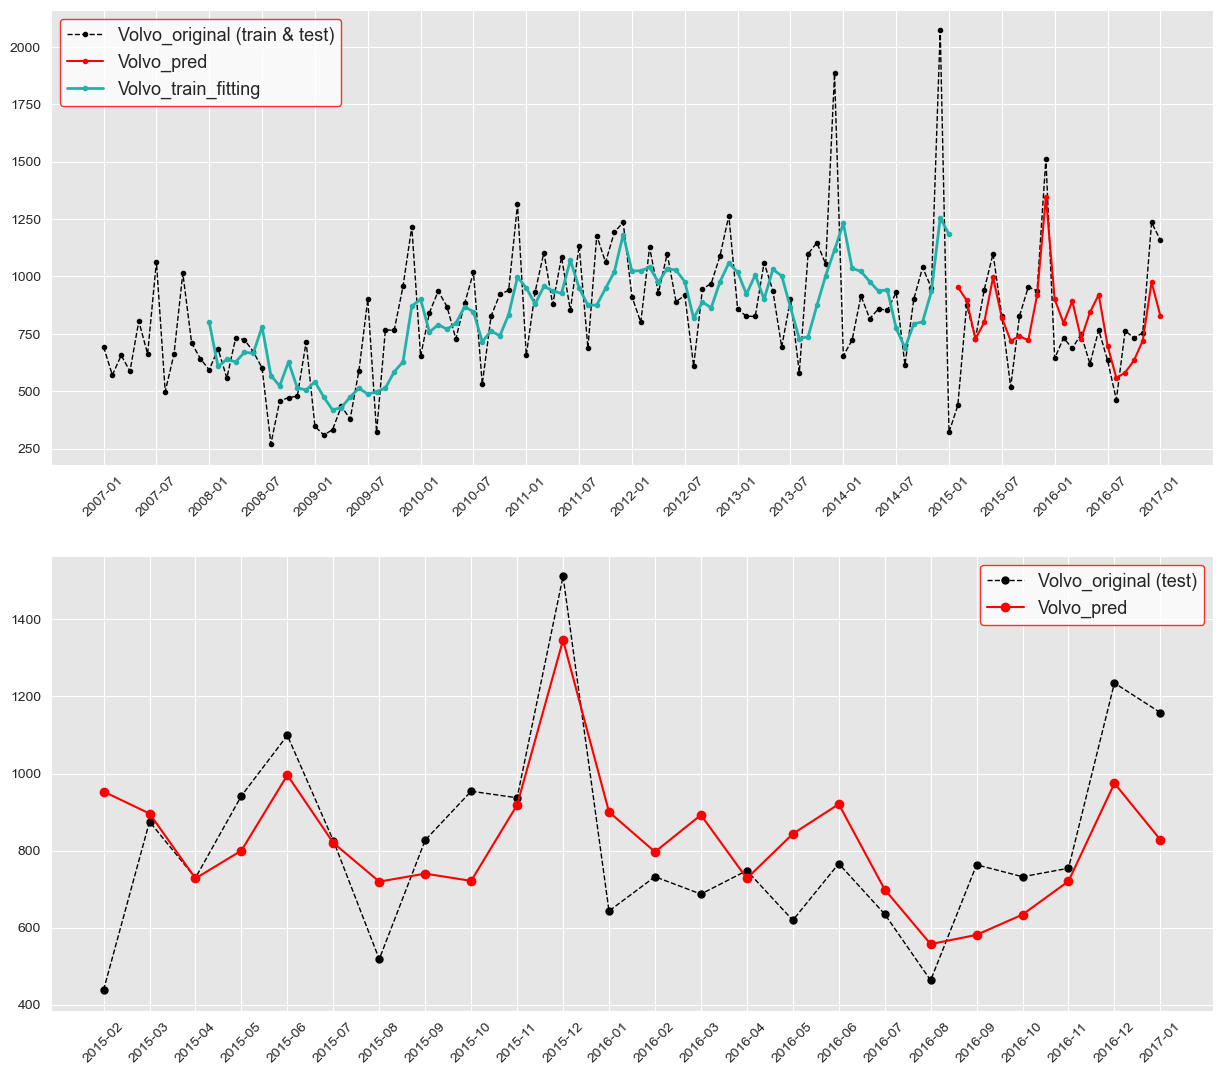

In [69]:
# Quindi adesso posso anche plottare visto che il dataset è completo e tutte le case hanno tutte le date

fig, ax = plt.subplots(2, 1, figsize = [15, 13])

lista_case = ['Volvo']

for brand in lista_case:
    
    # Grafico che mostra l'intera serie + le previsioni + il fitting del train
    ax[0].plot(df.T[brand], marker = 'o', markersize = 3, label = brand + '_original (train & test)', 
               linestyle = '--', lw = 1, c = 'black')
    
    ax[0].plot(df_y_pred.T[brand], marker = 'o', markersize = 3, label = brand + '_pred', c = 'red')
    ax[0].plot(df_y_train_pred.T[brand], marker = 'o', markersize = 3, label = brand + '_train_fitting', 
               lw = 2, c = 'lightseagreen')

    # Focus esclusivamente sulle previsioni
    ax[1].plot(df_y_test.T[brand], marker = 'o', markersize = 5, label = brand + '_original (test)', 
               linestyle = '--', linewidth = 1, c = 'black') if test_loops > 0 else '' # se non sono in validazione
    ax[1].plot(df_y_pred.T[brand], marker = 'o', label = brand + '_pred', c = 'red')

# Disegno la griglia ascisse dell'intera serie su ax[0]

step = 6
ax[0].set_xticks( df.T.index[ [j for j in np.arange(0, len(df.T.index), step)] ] )
ax[0].tick_params(axis='x', rotation=45)    
# Disegno la griglia ascisse dell'intera serie su ax[1]

step = 1
ax[1].set_xticks( df_y_pred.T.index[ [j for j in np.arange(0, len(df_y_pred.T.index), step)] ] )
ax[1].tick_params(axis='x', rotation=45)

# Legend
ax[0].legend(edgecolor = 'red', facecolor = 'white', fontsize = 13, loc = 'best')
ax[1].legend(edgecolor = 'red', facecolor = 'white', fontsize = 13, loc = 'best')

#plt.savefig(r'C:\Users\peria\Desktop\Img.png')

plt.show()

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# Multi-Output Regression
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


# LINEAR REGRESSION - previsione periodi multipli => ylen > 1

La **regressione lineare multivariata** nativamente permette di effettuare la multi-output regression

In [70]:
xlen = 12
ylen = 3
loops = df.shape[1] - xlen - ylen + 1
test_loops = 24

(X_train, y_train, X_test, y_test) = create_dataframe(df, xlen = xlen, ylen = ylen, test_loops = test_loops)

1st fitted value on the training set :  2008-01
Last fitted value on the training set :  2015-01
1st predictable test period :  2014-12
Last predictable test period :  2017-01


In [71]:
#X_train

#y_train

#X_test

#y_test

In [72]:
print('Dimensioni dataset di training: \n', 'X_train: ', X_train.shape, '\n y_train: ', y_train.shape, '\n\n')
print('Dimensioni dataset di testing: \n', 'X_test: ', X_test.shape, '\n y_test: ', y_test.shape)

Dimensioni dataset di training: 
 X_train:  (5395, 12) 
 y_train:  (5395, 3) 


Dimensioni dataset di testing: 
 X_test:  (1560, 12) 
 y_test:  (1560, 3)


In [73]:
y_train[0:df.shape[0], :]

array([[  15,    8,    8],
       [   0,    0,    1],
       [ 429,  486,  478],
       [ 368,  474,  379],
       [   0,    0,    1],
       [   0,    0,    0],
       [   0,    1,    1],
       [  28,   21,   37],
       [   0,    0,    0],
       [   5,    4,    1],
       [ 146,  148,  105],
       [   0,    0,    0],
       [   0,    0,    0],
       [  24,   26,   25],
       [  16,   20,   12],
       [   0,    2,    0],
       [  22,   19,   17],
       [   0,    0,    0],
       [ 942, 1016,  713],
       [ 549,  405,  293],
       [  97,  128,  175],
       [   0,    0,    0],
       [   0,    0,    0],
       [   0,    0,    0],
       [   2,    6,    8],
       [  32,   39,   28],
       [ 111,  133,  120],
       [   0,    0,    0],
       [   0,    0,    0],
       [   0,    0,    1],
       [  21,   16,   22],
       [  30,   15,   11],
       [   0,    0,    0],
       [  55,   41,   28],
       [   0,    0,    0],
       [   0,    1,    0],
       [ 280,  305,  514],
 

In [74]:
y_train[df.shape[0]:2*df.shape[0], :]


array([[   8,    8,    9],
       [   0,    1,    2],
       [ 486,  478,  662],
       [ 474,  379,  593],
       [   0,    1,    0],
       [   0,    0,    0],
       [   1,    1,    0],
       [  21,   37,   43],
       [   0,    0,    0],
       [   4,    1,    6],
       [ 148,  105,  170],
       [   0,    0,    0],
       [   0,    0,    0],
       [  26,   25,   26],
       [  20,   12,   18],
       [   2,    0,    1],
       [  19,   17,   72],
       [   0,    0,    0],
       [1016,  713,  854],
       [ 405,  293,  364],
       [ 128,  175,  187],
       [   0,    0,    0],
       [   0,    0,    1],
       [   0,    0,   13],
       [   6,    8,   19],
       [  39,   28,   34],
       [ 133,  120,   86],
       [   0,    0,    0],
       [   0,    0,    0],
       [   0,    1,    0],
       [  16,   22,   24],
       [  15,   11,   17],
       [   0,    0,    0],
       [  41,   28,   44],
       [   0,    0,    0],
       [   1,    0,    1],
       [ 305,  514,  317],
 

In [75]:
model = LinearRegression() # Create linear regression object

# TRAINING 
model.fit(X_train, y_train) # Train linear regression object by fitting X_train, y_train

LinearRegression()

Nella Multi-Output Linear Regression, è come se fittassi ylen-modelli lineari:
- Uno sul primo periodo temporale da prevedere
- Uno sul secondo periodo temporale da prevedere
- Uno sul terzo periodo temporale da prevedere 
- ... Ecc ... fino a y_len periodi temporali da prevedere

Quindi il risultato della regressione sono semplicemente 3 serie di coefficienti di regressione

In [76]:
# Coefficienti regressione
intercept = model.intercept_
coefs = model.coef_
for j in range(ylen):
    print('Intercept estimate model # ', j, ' : ', intercept[j])
    print('Coefficients estimate model # ', j, ': ', coefs[j], '\n')

Intercept estimate model #  0  :  1.459926941559786
Coefficients estimate model #  0 :  [ 0.27083962 -0.00677491 -0.10648221 -0.07445385 -0.03037639 -0.01018701
  0.15086308  0.03423975  0.04032015  0.20451362  0.22031462  0.30412308] 

Intercept estimate model #  1  :  1.6959858044347698
Coefficients estimate model #  1 :  [-0.04490311  0.3677225  -0.03704283 -0.12535907 -0.09071393 -0.01091412
  0.05923364  0.15457704  0.04660834  0.08562755  0.2758998   0.31908682] 

Intercept estimate model #  2  :  2.187846521246769
Coefficients estimate model #  2 :  [-0.03652594 -0.03282371  0.36882475 -0.03859285 -0.11195523 -0.09028537
  0.06630221  0.07154262  0.16549992  0.11894675  0.13912436  0.37641783] 



## - - - Analisi dei residui sul dataset di training (X_train, y_train) - - -
## - - - Calcolo y_train_pred

In [77]:
# PREDICTION SUL TRAIN per VEDERE COME FITTA IL MODELLO
y_train_pred = model.predict(X_train) # per visualizzare modello lineare fittato su X_train, y_train

# Residui
resid_train = y_train - y_train_pred

print('Prediction:\n', y_train_pred, '\n\nResiduals:\n', resid_train)

Prediction:
 [[1.68020040e+01 1.51372402e+01 2.03499705e+01]
 [1.65396737e+00 1.44104582e+00 2.03690087e+00]
 [4.95430176e+02 4.61642692e+02 5.25192245e+02]
 ...
 [1.97038138e+03 1.82814594e+03 1.82707284e+03]
 [9.50633739e+02 1.29905175e+03 8.00388330e+02]
 [1.45992694e+00 1.69598580e+00 2.18784652e+00]] 

Residuals:
 [[-1.80200400e+00 -7.13724017e+00 -1.23499705e+01]
 [-1.65396737e+00 -1.44104582e+00 -1.03690087e+00]
 [-6.64301765e+01  2.43573083e+01 -4.71922451e+01]
 ...
 [-5.03813834e+01  1.90854062e+02  2.29927159e+02]
 [-6.33738784e-01  7.72948249e+02 -4.79388330e+02]
 [-1.45992694e+00 -1.69598580e+00 -2.18784652e+00]]


In [78]:
def calc_skewness(a):
    l = len(a)
    m = a.mean()
    s = a.std()
    skewness = (1/l) * np.sum( (a - m)**3 ) / s**3
    return(skewness)

def calc_kurtosis(a):
    l = len(a)
    m = a.mean()
    s = a.std()
    kurt = (1/l) * np.sum( (a - m)**4 ) / s**4
    return(kurt)

def calc_residuals_statistics(R, ylen):
    
    list_mean = []
    list_std = []
    list_skew = []
    list_kurt = []
    
    for j in range(ylen):
        list_mean.append((R[:, j].mean()))
        list_std.append((R[:, j].std()))
        list_skew.append( calc_skewness(R[:, j]) )
        list_kurt.append( calc_kurtosis(R[:, j]) )
        
    df_stats = pd.DataFrame(np.array([list_mean, list_std, list_skew, list_kurt]), 
                         index = ['Mean_Resid', 'Std_Resid', 'Skew_Resid', 'Kurt_Resid'],
                         columns = ['Period_' + str(j+1) for j in range(ylen)])
    return(df_stats)

calc_residuals_statistics(resid_train, ylen)

Period_1      Period_2      Period_3
Mean_Resid -1.685810e-16  3.110320e-14 -6.911823e-15
Std_Resid   7.134680e+01  7.485750e+01  7.887147e+01
Skew_Resid  1.098590e+00  1.567039e+00  1.604193e+00
Kurt_Resid  3.280151e+01  3.070569e+01  2.798252e+01

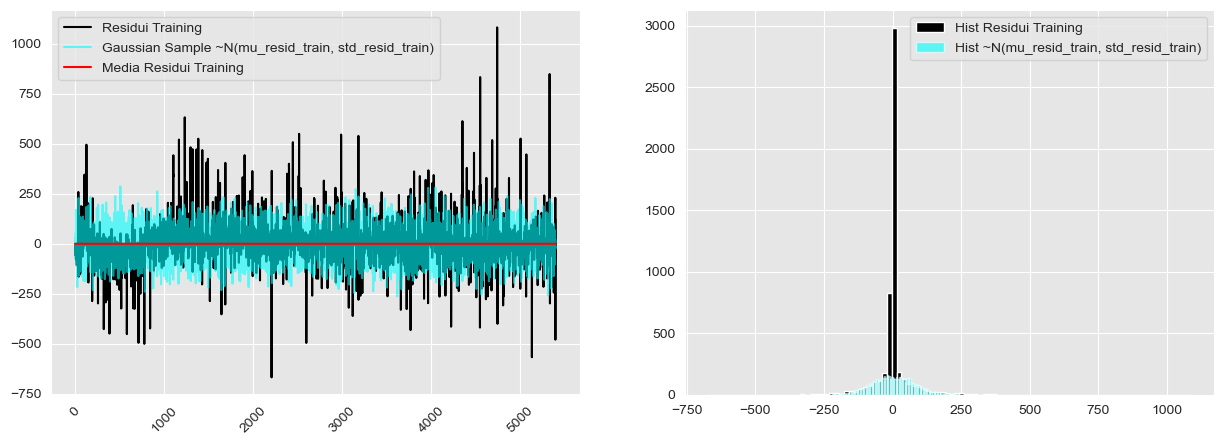

In [79]:
def plot_residuals(R):
    
    l = len(R)
    m = R.mean()
    s = R.std()
    
    fig, ax = plt.subplots(1, 2, figsize = (15, 5))
    
    sample = s * np.random.randn(l) + m

    # Andamento domanda
    ax[0].plot( R, color = 'black', label = 'Residui Training')
    ax[0].plot( sample, color = 'cyan', label = 'Gaussian Sample ~N(mu_resid_train, std_resid_train)', alpha = 0.6)
    ax[0].plot( m * np.ones(l), color = 'red', label = 'Media Residui Training')
    
    # Hist domanda
    ax[1].hist( R , color = 'black', bins = 100, label = 'Hist Residui Training')
    ax[1].hist(sample, color = 'cyan', alpha = 0.6, bins = 100, label = ['Hist ~N(mu_resid_train, std_resid_train)'])

    ax[0].tick_params(axis='x', labelrotation = 45)
    ax[0].legend()
    ax[1].legend()

    plt.show()
    
plot_residuals(resid_train[:, 2])

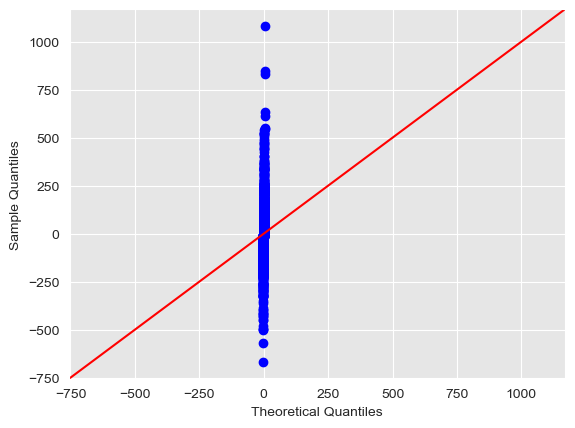

In [80]:
sm.qqplot(resid_train[:, 2], line ='45')
plt.show()

## - - - Calcolo statistiche sui coefficienti - - -

Di seguito calcolo alcune statistiche sui coefficienti, come:
- $\sigma_{\hat{\beta}}^{2} = \sigma^{2} (X^{T}X)^{-1}_{jj}$ con $\sigma^{2} = \frac{1}{n - p}\sum\limits_{i = 1}^{n}(y_{i} - \hat{y_{i}})^{2} = \frac{1}{n - p}\sum\limits_{i = 1}^{n}\epsilon_{i}^{2}$

-  $\sigma_{\hat{\beta}}$


- t_value => Valore t corrispondete al p-value del test statistico t-Student con H0:$\beta_{j} = 0$


- p_value del test statistico t-Student con H0:$\beta_{j} = 0$

In [81]:
X_sm = sm.add_constant(X_train)

# Siccome qui siamo in regressione multi-output, specifica quale colonna di y_train vuoi considerare
y_sm = y_train[:, 2]

model_sm = sm.OLS(y_sm, X_sm)
model_sm = model_sm.fit()

print(model_sm.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.942
Model:                            OLS   Adj. R-squared:                  0.942
Method:                 Least Squares   F-statistic:                     7287.
Date:                Sun, 16 Oct 2022   Prob (F-statistic):               0.00
Time:                        22:46:52   Log-Likelihood:                -31220.
No. Observations:                5395   AIC:                         6.247e+04
Df Residuals:                    5382   BIC:                         6.255e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.1878      1.209      1.809      0.0

## - - - Calcolo $R^{2}$ - - - 

In [82]:
# Calcolo varianza spiegata del modello

for j in range(ylen):
    std_y_train = y_train[:, j].std()
    std_resid_train = resid_train[:, j].std()
    R_squared = 1 - std_resid_train**2 / std_y_train**2
    print('R^2 previsione perido #', j, ' : ', R_squared)

R^2 previsione perido # 0  :  0.952150171029667
R^2 previsione perido # 1  :  0.9477425129127649
R^2 previsione perido # 2  :  0.9420205696500739


## - - - Predizione sul test - - -

In [83]:
# Preduzione sul TEST
y_pred = model.predict(X_test)

In [84]:
#*************************************************************************************************************************#
#*************************************************************************************************************************#

# - - - Creazione metriche di errore - - - 

Adesso creo un dataset con le metriche di errore

In [85]:
for j in range(ylen):
    print('\nForecasting Period #', j+1)
    ML_forecast_KPI(y_train[:, j], y_train_pred[:, j], y_test[:, j], y_pred[:, j])


Forecasting Period # 1
         MAE%   RMSE%   BIAS%
Train  0.1771  0.4339 -0.0000
Test   0.1762  0.4488  0.0069

Forecasting Period # 2
         MAE%   RMSE%   BIAS%
Train  0.1881  0.4539  0.0000
Test   0.1886  0.4596  0.0039

Forecasting Period # 3
         MAE%   RMSE%   BIAS%
Train  0.2001  0.4782 -0.0000
Test   0.1889  0.4571  0.0152


# - - - Visualizzazione risultati previsione - - - 

Questa parte non è immediata, guardare "Data Science for Supply Chain Forecasting - SCRITTO" per la spiegazione.

Dal formato che avevamo per fare la previsione, riottengo dei dataset **df_y_test** e **df_y_pred** così fatti:
Sulle righe ci sono le marche di auto => devo fare un reshape + transpose. 
- Il reshape(test_loops, -1) mi fa ottenere un array con tante righe quanti i test_loops e tante colonne quante le marche di auto
- Trasponendo faccio in modo di ottenere le auto sulle righe e sulle colonne i periodi

Inoltre ho estratto un file excel chiamato "Help_per_ricreare_df_finali.xlsx". Questo serve per visualizzare cosa fanno i vari algoritmi che consentono di ricreare:
     
- df_y_train
- df_y_train_pred
- df_y_test (ammesso che non sia in pura previsione e quindi questo non esista)
- df_y_pred

### Riaggregare y_train e y_train_pred in un dataset => df_y_train & df_y_train_pred

In [86]:
# Scegli quale periodo futuro che è stato precedentemente predetto analizzare
t = 2

In [87]:
if test_loops > 0 : # Se faccio validazione (i.e. test_loops > 0)
    df_y_train = pd.DataFrame(y_train[:, t].reshape((loops-test_loops, -1)).transpose(), 
                              index = df.index,
                              columns = df.columns[(xlen + t) : (-test_loops - ylen + t + 1)])
    
else: # Se faccio semplice forecast futura (i.e.test_loops = 0)
    if (-ylen + t + 1) == 0:
        df_y_train = pd.DataFrame(y_train[:, t].reshape((loops-test_loops, -1)).transpose(), 
                                  index = df.index,
                                  columns = df.columns[(xlen + t) : ])
                                  
    else:
         df_y_train = pd.DataFrame(y_train[:, t].reshape((loops-test_loops, -1)).transpose(), 
                                  index = df.index,
                                  columns = df.columns[(xlen + t) : (- ylen + t + 1)])

df_y_train.head()

Period        2008-03  2008-04  2008-05  2008-06  2008-07  2008-08  2008-09  \
Make                                                                          
Alfa Romeo          8        9        4       11       15       11        4   
Aston Martin        1        2        0        2        0        0        0   
Audi              478      662      569      693      594      574      545   
BMW               379      593      441      593      386      278      371   
Bentley             1        0        0        0        0        0        0   

Period        2008-10  2008-11  2008-12  ...  2014-04  2014-05  2014-06  \
Make                                     ...                              
Alfa Romeo          9        7        7  ...        6        8        4   
Aston Martin        0        0        0  ...        0        0        0   
Audi              578      522      625  ...      704      721      548   
BMW               395      262      423  ...      946      733      644   
Bentley             0        0        0  ...        0        0        0   

Period        2014-07  2014-08  2014-09  2014-10  2014-11  2014-12  2015-01  
Make                                                                         
Alfa Romeo         12       15        8        7        2        1        9  
Aston Martin        0        0        0        0        0        0        0  
Audi              609      575      448      606      516      604      302  
BMW               670      816      670      778      710      804      649  
Bentley             0        0        0        0        0        0        0  

[5 rows x 83 columns]

In [88]:
if test_loops > 0 : # Se faccio validazione (i.e. test_loops > 0)
    df_y_train_pred = pd.DataFrame(y_train_pred[:, t].reshape((loops-test_loops, -1)).transpose(), 
                                   index = df.index,
                                   columns = df.columns[(xlen + t) : (-test_loops-ylen + t + 1)])

else:# Se faccio semplice forecast futura (i.e.test_loops = 0)
    
    if (-ylen + t + 1) == 0:
        df_y_train_pred = pd.DataFrame(y_train_pred[:, t].reshape((loops-test_loops, -1)).transpose(), 
                                       index = df.index,
                                       columns = df.columns[(xlen + t) : ])
    else: 
         df_y_train_pred = pd.DataFrame(y_train_pred[:, t].reshape((loops-test_loops, -1)).transpose(), 
                                       index = df.index,
                                       columns = df.columns[(xlen + t) : (- ylen + t + 1) ])

df_y_train_pred.head()

Period           2008-03     2008-04     2008-05     2008-06     2008-07  \
Make                                                                       
Alfa Romeo     20.349971   18.507862   15.858148   16.741427   13.626521   
Aston Martin    2.036901    1.393930    3.174975    3.423665    3.941706   
Audi          525.192245  473.839491  493.392469  465.464087  560.577231   
BMW           436.824942  411.999392  476.639609  483.777599  489.581185   
Bentley         2.473979    2.215016    2.268200    3.098589    2.365690   

Period           2008-08     2008-09     2008-10     2008-11     2008-12  ...  \
Make                                                                      ...   
Alfa Romeo      9.562435   11.176342   10.790096   14.110681   14.303892  ...   
Aston Martin    2.376993    3.234498    2.868638    2.635127    2.561165  ...   
Audi          570.414551  555.078565  627.988657  579.501844  578.472227  ...   
BMW           411.413910  425.444879  513.990654  433.141407  445.028974  ...   
Bentley         2.336570    2.263061    2.147434    2.215556    2.466386  ...   

Period           2014-04     2014-05     2014-06     2014-07     2014-08  \
Make                                                                       
Alfa Romeo     10.353553    6.510008   12.906066   10.161961   12.377049   
Aston Martin    2.429860    2.043068    2.112728    2.556671    2.155023   
Audi          728.488919  567.400606  531.446695  644.619720  659.758363   
BMW           740.364415  776.057435  757.411926  824.785093  823.351240   
Bentley         2.316820    2.259389    2.254149    2.097561    2.075891   

Period           2014-09     2014-10     2014-11     2014-12     2015-01  
Make                                                                      
Alfa Romeo      8.960987   14.223566   12.510965    9.625930   10.017220  
Aston Martin    2.151321    2.187847    2.187847    2.187847    2.187847  
Audi          601.799136  660.443622  578.335069  510.218214  600.281003  
BMW           836.959952  733.867242  707.118206  562.636713  760.338805  
Bentley         2.149254    2.556671    2.155023    2.151321    2.187847  

[5 rows x 83 columns]

### Riaggregare TEST e PREVISIONE in dei dataset => df_y_test e df_y_pred

In [89]:
if test_loops > 0 : # Se faccio validazione (i.e. test_loops > 0)
    
    if (-ylen + t + 1) == 0:
        df_y_test = pd.DataFrame(y_test[:, t].reshape((test_loops, -1)).transpose(), 
                                 index = df.index,
                                 # il +1 perché il secondo estremo non è incluso nello slicing di un array
                                 columns = df.columns[(-test_loops-ylen + t + 1):])
    
    else:
        df_y_test = pd.DataFrame(y_test[:, t].reshape((test_loops, -1)).transpose(), 
                                 index = df.index,
                                 # il +1 perché il secondo estremo non è incluso nello slicing di un array
                                 columns = df.columns[(-test_loops - ylen + t + 1):(-ylen + t + 1)])
    df_y_test.head()
    
else: # Se faccio semplice forecast futura (i.e.test_loops = 0)
    print('No df_y_test perché non sono in validazione')

In [90]:
if test_loops > 0 : # Se faccio validazione (i.e. test_loops > 0)
    
    if (-ylen + t + 1) == 0:
        df_y_pred = pd.DataFrame(y_pred[:, t].reshape((test_loops, -1)).transpose(), 
                                 index = df.index,
                                 # il +1 perché il secondo estremo non è incluso nello slicing di un array
                                 columns = df.columns[(-test_loops-ylen + t + 1):])
    
    else:
        df_y_pred = pd.DataFrame(y_pred[:, t].reshape((test_loops, -1)).transpose(), 
                                 index = df.index,
                                 # il +1 perché il secondo estremo non è incluso nello slicing di un array
                                 columns = df.columns[(-test_loops-ylen + t + 1):(-ylen + t + 1)])
    
else: # Se faccio semplice forecast futura (i.e.test_loops = 0)
    df_y_pred = pd.DataFrame(y_pred, index = df.index, columns = ['2017.02', '2017.03', '2017.04'])
    
#df_y_pred = pd.DataFrame(y_pred, index = df.index, columns = '2017.02')
    
df_y_pred.head()

Period           2015-02     2015-03     2015-04     2015-05     2015-06  \
Make                                                                       
Alfa Romeo      8.151185    9.089889    8.507268    4.797302    3.428274   
Aston Martin    2.187847    2.187847    2.187847    2.187847    2.187847   
Audi          505.316918  540.993568  508.690297  533.676723  530.620308   
BMW           756.098676  844.865607  795.539439  673.752350  700.001628   
Bentley         2.187847    2.187847    2.187847    2.187847    2.187847   

Period           2015-07     2015-08     2015-09     2015-10     2015-11  ...  \
Make                                                                      ...   
Alfa Romeo      7.442928    8.686382    6.691661    7.896835    5.291712  ...   
Aston Martin    2.940682    3.218931    2.703989    2.756740    2.661932  ...   
Audi          572.719392  566.486155  544.913039  701.896813  625.040543  ...   
BMW           697.425956  741.778248  737.569569  713.765389  782.659366  ...   
Bentley         2.187847    2.187847    2.187847    2.187847    2.187847  ...   

Period           2016-04     2016-05     2016-06     2016-07     2016-08  \
Make                                                                       
Alfa Romeo      3.292246    3.539441    3.958318    6.783127    4.474872   
Aston Martin    2.848310    2.859849    2.801983    2.393043    2.425740   
Audi          560.121821  522.974102  566.078551  675.957536  543.531701   
BMW           989.280421  915.622935  984.616286  913.348643  905.829986   
Bentley         2.187847    2.187847    2.187847    2.187847    2.187847   

Period           2016-09     2016-10     2016-11      2016-12      2017-01  
Make                                                                        
Alfa Romeo      4.853605    3.043325    6.029901     9.902493     5.600577  
Aston Martin    2.895264    2.470056    2.439398     2.172776     2.035479  
Audi          535.772990  626.760275  689.174105   641.991062   633.389837  
BMW           837.962989  820.014639  890.030259  1016.555357  1021.373097  
Bentley         2.564264    2.703389    2.822335     2.611418     2.543836  

[5 rows x 24 columns]

### Grafico

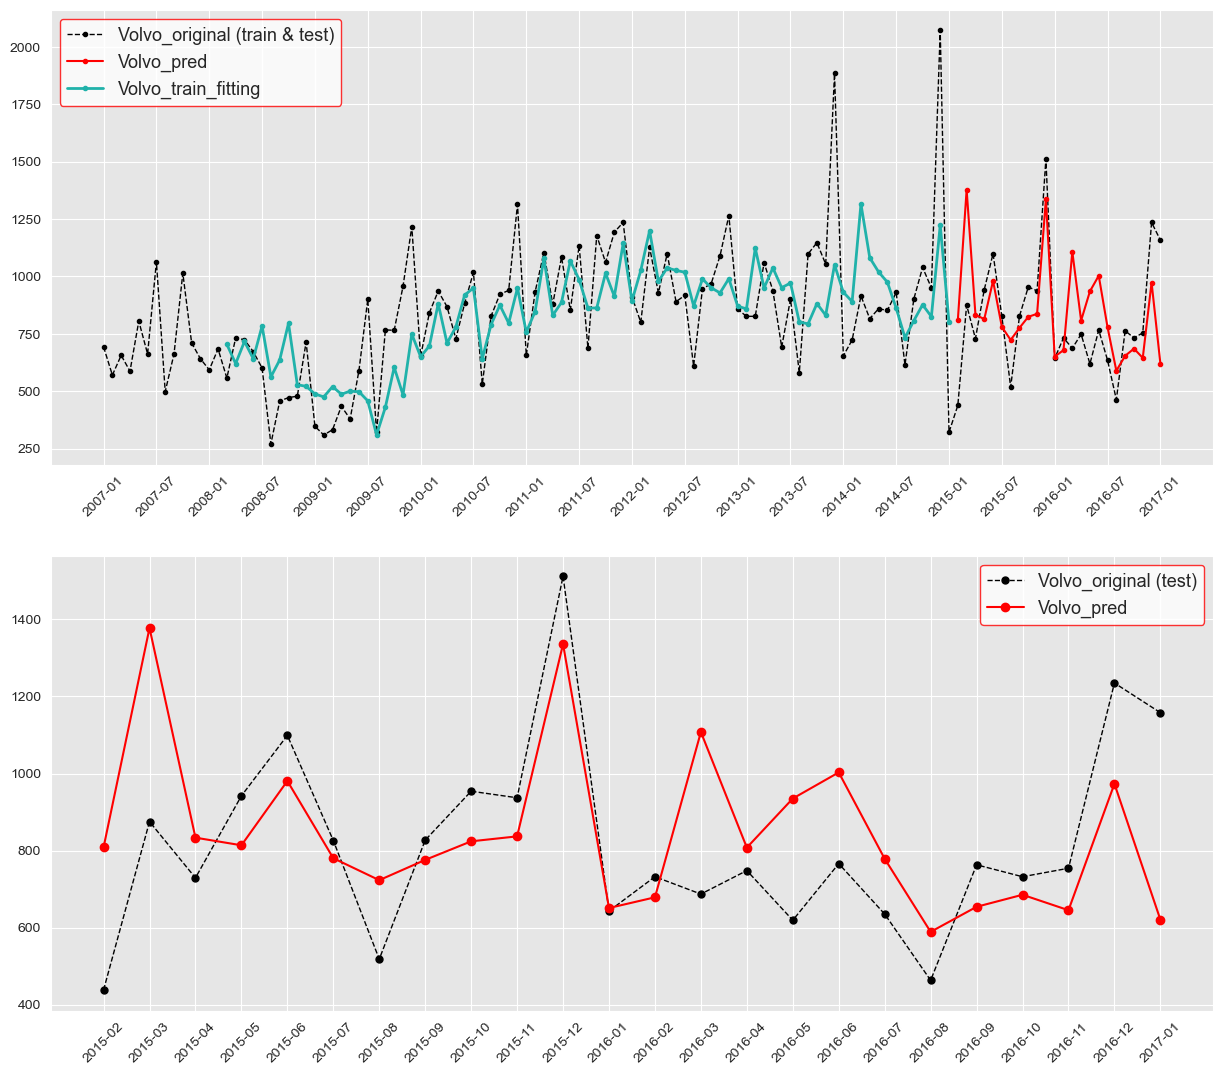

In [91]:
# Quindi adesso posso anche plottare visto che il dataset è completo e tutte le case hanno tutte le date

fig, ax = plt.subplots(2, 1, figsize = [15, 13])

lista_case = ['Volvo']

for brand in lista_case:
    
    # Grafico che mostra l'intera serie + le previsioni + il fitting del train
    ax[0].plot(df.T[brand], marker = 'o', markersize = 3, label = brand + '_original (train & test)', 
               linestyle = '--', lw = 1, c = 'black')
    
    ax[0].plot(df_y_pred.T[brand], marker = 'o', markersize = 3, label = brand + '_pred', c = 'red')
    ax[0].plot(df_y_train_pred.T[brand], marker = 'o', markersize = 3, label = brand + '_train_fitting', 
               lw = 2, c = 'lightseagreen')

    # Focus esclusivamente sulle previsioni
    ax[1].plot(df_y_test.T[brand], marker = 'o', markersize = 5, label = brand + '_original (test)', 
               linestyle = '--', linewidth = 1, c = 'black') if test_loops > 0 else '' # se non sono in validazione
    ax[1].plot(df_y_pred.T[brand], marker = 'o', label = brand + '_pred', c = 'red')

# Disegno la griglia ascisse dell'intera serie su ax[0]

step = 6
ax[0].set_xticks( df.T.index[ [j for j in np.arange(0, len(df.T.index), step)] ] )
ax[0].tick_params(axis='x', rotation=45)    
# Disegno la griglia ascisse dell'intera serie su ax[1]

step = 1
ax[1].set_xticks( df_y_pred.T.index[ [j for j in np.arange(0, len(df_y_pred.T.index), step)] ] )
ax[1].tick_params(axis='x', rotation=45)

# Legend
ax[0].legend(edgecolor = 'red', facecolor = 'white', fontsize = 13, loc = 'best')
ax[1].legend(edgecolor = 'red', facecolor = 'white', fontsize = 13, loc = 'best')

#plt.savefig(r'C:\Users\peria\Desktop\Img.png')

plt.show()